### Opening tensorboard if necessary

In [ ]:
"""
# not working on compute4 :( 
%load_ext tensorboard
%tensorboard --logdir logs
"""

# Init: opening measurement file and creating synthetic dataset

In [13]:
# imports libraries
import time
import tensorflow as tf # tensorflow 2.10
import numpy as np # numpy 1.21.5
import matplotlib.pyplot as plt
import random
import datetime
import json

# my imports
from data_generation import get_sample, get_sample2 
from evals_WGANGP import evals_WGANGP
from evals_dB_WGANGP import evals_dB_WGANGP
from evecs_WGANGP import evecs_WGANGP
from main_evecs_WGANGP import main_evecs_WGANGP
from noise_evecs_WGANGP import noise_evecs_WGANGP
from measurement import get_measurement_sample
from eigenmanipulation import normalize_evals, normalize_evecs, levelify, unlevelify
from beamforming import beamform, get_csm, get_rank_I_csm
from plotting_loss import plot_loss

# config files
from msm_config2022 import FILES, LOC # config file for measurements with names 2022- ... .h5


# ==============================================================================================================
# Code necessary to prevent the container from occupying the whole GPU RAM.
# ==============================================================================================================

gpu_available = tf.config.list_physical_devices('GPU')

# only occupy needed GPU RAM 
for gpu in gpu_available:
    tf.config.experimental.set_memory_growth(gpu, True)

In [ ]:
"""
start = time.time()

filename_examples = ["2022-01-26_16-44-23_105567.h5",
                    "2022-01-26_16-37-41_557896.h5",
                    "2022-01-26_16-41-15_436578.h5",
                    "2022-01-26_16-27-11_017085.h5",
                    "2022-01-26_16-21-22_252111.h5",
                    "2022-01-26_16-21-05_110135.h5",
                    "2022-01-26_16-18-19_438409.h5"]


# General variable
BATCH_SIZE = 16
NB_SYNTHETIC_BATCH = 1000 # for the synthetic dataset
NB_MEASUREMENT_BATCH = 200 # for the measurement dataset
NB_STEPS = 5

# Variables to access the measurements
MEASUREMENT_PATH = "../Data/Measurement/td/"
MEASUREMENT_PATH_C4 = "../../../shared/measured_data/td/"
index = 3 # np.random.randint(len(filename_examples))
FILENAME = filename_examples[index]
print(f"measurement used: {FILENAME[:-3]}")
MEASUREMENT_NAME = f"{MEASUREMENT_PATH}{FILENAME}"

# Data to use
loc_dict = {f"{name}.h5": loc for name, loc in zip(FILES, LOC)}
loc = loc_dict[FILENAME]
LOCATION=(loc[0], loc[1], 0.5) # location of the sound source
FREQ_INDEX = 14
BLOCKSIZE = 128
APERTURE_SIZE = 1.5 # measurement
SPEED_OF_SOUND = 343 #[m/s]
SAMPLING_FREQUENCY = 51200 # measurement 2022
FREQ = (SAMPLING_FREQUENCY*FREQ_INDEX)/BLOCKSIZE

HELMOTZ_NUMBER_MEASUREMENT = (FREQ*APERTURE_SIZE)/SPEED_OF_SOUND
HELMOTZ_NUMBER_SYNTHETIC = FREQ/SPEED_OF_SOUND



# Generating synthetic dataset

synthetic_dataset = [get_sample2(loc=LOCATION, 
                                 helmotz_number=HELMOTZ_NUMBER_SYNTHETIC)
                     for _ in range(BATCH_SIZE*NB_SYNTHETIC_BATCH)]



main_evecs_dataset = tf.convert_to_tensor([s[0] for s in synthetic_dataset])
noise_evecs_dataset = tf.convert_to_tensor([s[1] for s in synthetic_dataset])
evals_dataset = tf.convert_to_tensor([s[2] for s in synthetic_dataset])
evals_dB_dataset = tf.convert_to_tensor([s[3] for s in synthetic_dataset])

# Opening measurement dataset

measurement_dataset = [get_measurement_sample(measurement_name=MEASUREMENT_NAME,
                                             freq_index=FREQ_INDEX)
                       for _ in range(BATCH_SIZE*NB_MEASUREMENT_BATCH)]

measurement_main_evecs_dataset = tf.convert_to_tensor([m[0] for m in measurement_dataset])
measurement_noise_evecs_dataset = tf.convert_to_tensor([m[1] for m in measurement_dataset])
measurement_evals_dataset = tf.convert_to_tensor([m[2] for m in measurement_dataset])
measurement_evals_dB_dataset = tf.convert_to_tensor([m[3] for m in measurement_dataset])

diff = time.time() - start
print(f"completed in {diff}s")

# On computer4, for: BATCH_SIZE = 16, NB_SYNTHETIC_BATCH = 500, NB_MEASUREMENT_BATCH = 100 --> completed in approx. 30min
"""

In [ ]:
"""
# RANK I Beamforming validation test ==========================================================================
print(f"source is located at (x,y) = ({LOCATION[0]},{LOCATION[1]})")

NUMFREQ = 1
NUMCHANNELS = 64

# 1 with synthetic ============================================================================================
generated_evals = evals_dataset[0, :, :,:]
evals_vec_numpy = normalize_evals(np.sort(np.array(generated_evals[ :, :, 0]).flatten()))
evals_vec = tf.convert_to_tensor(evals_vec_numpy)

main_evec = normalize_evecs(main_evecs_dataset[0, :, :,:])
main_evec_real = main_evec[:, 0, 0] 
main_evec_imag = main_evec[:, 0, 1]


rank_I_csm = get_rank_I_csm(main_evec_real, main_evec_imag, evals_vec).numpy()
rank_I_csm = np.reshape(rank_I_csm, newshape=(NUMFREQ,NUMCHANNELS,NUMCHANNELS))
beamform(rank_I_csm, helmotz_number=HELMOTZ_NUMBER_SYNTHETIC, measurement=False)


# 2 with measurement ===========================================================================================
generated_evals = measurement_evals_dataset[0, :, :,:]
evals_vec_numpy = normalize_evals(np.sort(np.array(generated_evals[ :, :, 0]).flatten()))
evals_vec = tf.convert_to_tensor(evals_vec_numpy)

main_evec = normalize_evecs(measurement_main_evecs_dataset[0, :, :,:])
main_evec_real = main_evec[:, 0, 0] 
main_evec_imag = main_evec[:, 0, 1]

rank_I_csm = get_rank_I_csm(main_evec_real, main_evec_imag, evals_vec).numpy()
rank_I_csm = np.reshape(rank_I_csm, newshape=(NUMFREQ,NUMCHANNELS,NUMCHANNELS))
beamform(rank_I_csm, helmotz_number=HELMOTZ_NUMBER_MEASUREMENT, measurement=True)
"""

### Misc: function to save and load datasets instead of generating them

In [ ]:
"""
# Save datasets:
datasets = [main_evecs_dataset,
            noise_evecs_dataset,
            evals_dataset,
            evals_dB_dataset,
            measurement_main_evecs_dataset,
            measurement_noise_evecs_dataset,
            measurement_evals_dataset,
            measurement_evals_dB_dataset]

name_datasets = ["main_evecs_dataset",
                "noise_evecs_dataset",
                "evals_dataset",
                "evals_dB_dataset",
                "measurement_main_evecs_dataset",
                "measurement_noise_evecs_dataset",
                "measurement_evals_dataset",
                "measurement_evals_dB_dataset"]

for dataset, name in zip(datasets, name_datasets):
    numpy_dataset = np.array(dataset)
    with open(f'datasets_backups/{name}.npy', 'wb') as f:
        np.save(f, numpy_dataset)
        
        
# Save variables:
variable_dict = {
        "BATCH_SIZE":BATCH_SIZE,
        "NB_SYNTHETIC_BATCH":NB_SYNTHETIC_BATCH,
        "NB_MEASUREMENT_BATCH":NB_MEASUREMENT_BATCH,
        "NB_STEPS":NB_STEPS,
        "MEASUREMENT_PATH":MEASUREMENT_PATH,
        "MEASUREMENT_PATH_C4":MEASUREMENT_PATH_C4,
        "FILENAME":FILENAME,
        "MEASUREMENT_NAME":MEASUREMENT_NAME,
        "LOCATION":LOCATION,
        "FREQ_INDEX":FREQ_INDEX,
        "BLOCKSIZE":BLOCKSIZE,
        "APERTURE_SIZE":APERTURE_SIZE,
        "SPEED_OF_SOUND":SPEED_OF_SOUND,
        "SAMPLING_FREQUENCY":SAMPLING_FREQUENCY,
        "FREQ":FREQ,
        "HELMOTZ_NUMBER_MEASUREMENT":HELMOTZ_NUMBER_MEASUREMENT,
        "HELMOTZ_NUMBER_SYNTHETIC":HELMOTZ_NUMBER_SYNTHETIC
}

variable_dict_json = json.dumps(variable_dict)

with open("datasets_backups/variable_dict.json","w") as f:
    f.write(variable_dict_json)"""

In [14]:
# Load from backup instead
with open(f'datasets_backups/main_evecs_dataset.npy', 'rb') as f:
    main_evecs_dataset = tf.convert_to_tensor(np.load(f))
    
with open(f'datasets_backups/noise_evecs_dataset.npy', 'rb') as f:
    noise_evecs_dataset = tf.convert_to_tensor(np.load(f))
    
with open(f'datasets_backups/evals_dataset.npy', 'rb') as f:
    evals_dataset = tf.convert_to_tensor(np.load(f))
    
with open(f'datasets_backups/evals_dB_dataset.npy', 'rb') as f:
    evals_dB_dataset = tf.convert_to_tensor(np.load(f))
    
with open(f'datasets_backups/measurement_main_evecs_dataset.npy', 'rb') as f:
    measurement_main_evecs_dataset = tf.convert_to_tensor(np.load(f))
    
with open(f'datasets_backups/measurement_noise_evecs_dataset.npy', 'rb') as f:
    measurement_noise_evecs_dataset = tf.convert_to_tensor(np.load(f))
    
with open(f'datasets_backups/measurement_evals_dataset.npy', 'rb') as f:
    measurement_evals_dataset = tf.convert_to_tensor(np.load(f))
    
with open(f'datasets_backups/measurement_evals_dB_dataset.npy', 'rb') as f:
    measurement_evals_dB_dataset = tf.convert_to_tensor(np.load(f))
    
# Load variable:
with open("datasets_backups/variable_dict.json","r") as f:
    variable_dict = json.load(f)

BATCH_SIZE = variable_dict["BATCH_SIZE"]
NB_SYNTHETIC_BATCH = variable_dict["NB_SYNTHETIC_BATCH"]
NB_MEASUREMENT_BATCH = variable_dict["NB_MEASUREMENT_BATCH"]
NB_STEPS = variable_dict["NB_STEPS"]
MEASUREMENT_PATH = variable_dict["MEASUREMENT_PATH"]
MEASUREMENT_PATH_C4 = variable_dict["MEASUREMENT_PATH_C4"]
FILENAME = variable_dict["FILENAME"]
MEASUREMENT_NAME = variable_dict["MEASUREMENT_NAME"]
LOCATION = variable_dict["LOCATION"]
FREQ_INDEX = variable_dict["FREQ_INDEX"]
BLOCKSIZE = variable_dict["BLOCKSIZE"]
APERTURE_SIZE = variable_dict["APERTURE_SIZE"]
SPEED_OF_SOUND = variable_dict["SPEED_OF_SOUND"]
SAMPLING_FREQUENCY = variable_dict["SAMPLING_FREQUENCY"]
FREQ = variable_dict["FREQ"]
HELMOTZ_NUMBER_MEASUREMENT = variable_dict["HELMOTZ_NUMBER_MEASUREMENT"]
HELMOTZ_NUMBER_SYNTHETIC = variable_dict["HELMOTZ_NUMBER_SYNTHETIC"]

In [15]:
# Print dimension of datasets and variable

print("")
print("=== Datasets ==============================================")
print("")

print(f"- main_evecs_dataset.shape: {main_evecs_dataset.shape}")
print(f"- noise_evecs_dataset.shape: {noise_evecs_dataset.shape}")
print(f"- evals_dataset.shape: {evals_dataset.shape}")
print(f"- evals_dB_dataset.shape: {evals_dB_dataset.shape}")
print(f"- measurement_noise_evecs_dataset.shape: {measurement_noise_evecs_dataset.shape}")
print(f"- measurement_noise_evecs_dataset.shape: {measurement_noise_evecs_dataset.shape}")
print(f"- measurement_evals_dataset.shape: {measurement_evals_dataset.shape}")
print(f"- measurement_evals_dB_dataset.shape: {measurement_evals_dB_dataset.shape}")

print("")
print("")
print("=== Variables =============================================")
print("")

print(f"- BATCH_SIZE: {BATCH_SIZE}")
print(f"- NB_SYNTHETIC_BATCH: {NB_SYNTHETIC_BATCH}")
print(f"- NB_MEASUREMENT_BATCH: {NB_MEASUREMENT_BATCH}")
print(f"- NB_STEPS: {NB_STEPS}")
print(f"- MEASUREMENT_PATH: {MEASUREMENT_PATH}")
print(f"- MEASUREMENT_PATH_C4: {MEASUREMENT_PATH_C4}")
print(f"- FILENAME: {FILENAME}")
print(f"- MEASUREMENT_NAME: {MEASUREMENT_NAME}")
print(f"- LOCATION: {LOCATION}")
print(f"- FREQ_INDEX: {FREQ_INDEX}")
print(f"- BLOCKSIZE: {BLOCKSIZE}")
print(f"- APERTURE_SIZE: {APERTURE_SIZE}")
print(f"- SPEED_OF_SOUND: {SPEED_OF_SOUND}")
print(f"- SAMPLING_FREQUENCY: {SAMPLING_FREQUENCY}")
print(f"- FREQ: {FREQ}")
print(f"- HELMOTZ_NUMBER_MEASUREMENT: {HELMOTZ_NUMBER_MEASUREMENT}")
print(f"- HELMOTZ_NUMBER_SYNTHETIC: {HELMOTZ_NUMBER_SYNTHETIC}")




=== Datasets ==============================================

- main_evecs_dataset.shape: (16000, 64, 1, 2)
- noise_evecs_dataset.shape: (16000, 64, 63, 2)
- evals_dataset.shape: (16000, 8, 8, 1)
- evals_dB_dataset.shape: (16000, 8, 8, 1)
- measurement_noise_evecs_dataset.shape: (3200, 64, 63, 2)
- measurement_noise_evecs_dataset.shape: (3200, 64, 63, 2)
- measurement_evals_dataset.shape: (3200, 8, 8, 1)
- measurement_evals_dB_dataset.shape: (3200, 8, 8, 1)


=== Variables =============================================

- BATCH_SIZE: 16
- NB_SYNTHETIC_BATCH: 1000
- NB_MEASUREMENT_BATCH: 200
- NB_STEPS: 5
- MEASUREMENT_PATH: ../Data/Measurement/td/
- MEASUREMENT_PATH_C4: ../../../shared/measured_data/td/
- FILENAME: 2022-01-26_16-27-11_017085.h5
- MEASUREMENT_NAME: ../Data/Measurement/td/2022-01-26_16-27-11_017085.h5
- LOCATION: [-0.09, -0.111, 0.5]
- FREQ_INDEX: 14
- BLOCKSIZE: 128
- APERTURE_SIZE: 1.5
- SPEED_OF_SOUND: 343
- SAMPLING_FREQUENCY: 51200
- FREQ: 5600.0
- HELMOTZ_NUMBER_MEA

In [ ]:
# GRID SEARCH: for noise evecs:


latent_dim_list =  [2048] #[2**exp for exp in range(7,20)], [1024, 2048, 4096, 8192]
critic_extra_steps_list = [10]#[3, 4, 5]


for latent_dim in latent_dim_list:
    for critic_extra_steps in critic_extra_steps_list:
        print("========================================")
        print("PARAMETERS =============================")
        print("========================================")
        print(f"latent_dim = {latent_dim}")
        print(f"critic_extra_steps = {critic_extra_steps}")
        print("========================================")
        print("========================================")

        # Creating GAN
        noise_evecs_wgangp = noise_evecs_WGANGP(latent_dim=latent_dim, critic_extra_steps=critic_extra_steps)

        # Compiling GAN
        noise_evecs_wgangp.compile()

        # Training GAN
        history = noise_evecs_wgangp.fit(
            noise_evecs_dataset,
            batch_size=BATCH_SIZE,
            epochs=100,
            steps_per_epoch=1000,
            #callbacks=[tensorboard_callback, checkpoint_callback]
        )
        
        plot_loss(history)

In [ ]:
# Testing RANK I beamforinmg in this cell:



# ====================================================================================================
# VERSION AVANT CORRECTION DES SETS EVECS
generated_evecs = tf.concat([noise_evecs_dataset[0, :, :,:], 
                     main_evecs_dataset[0, :, :,:]],
                    axis=-3)


generated_main_evec = generated_evecs[:,-1,:]

main_evec_real = generated_main_evec[:, 0] 
main_evec_imag = generated_main_evec[:, 1]
# ====================================================================================================

# reshape data
generated_evals = evals_dataset[0, :, :,:]
evals_vec_numpy = normalize_evals(np.sort(np.array(generated_evals[ :, :, 0]).flatten()))
evals_vec = tf.convert_to_tensor(evals_vec_numpy)

"""
# VERSION APRES CORRECTION DES SETS EVECS
main_evec = normalize_evecs(measurement_main_evecs_dataset[0, :, :,:])
main_evec_real = main_evec[0, :, 0] 
main_evec_imag = main_evec[0, :, 1]
"""

rank_I_csm = get_rank_I_csm(main_evec_real, main_evec_imag, evals_vec).numpy()

NUMFREQ = 1 # one freq with index bin = 13 ? -> is that accurate ?
NUMCHANNELS = 64

rank_I_csm = np.reshape(rank_I_csm, newshape=(NUMFREQ,NUMCHANNELS,NUMCHANNELS))

#beamform(rank_I_csm, helmotz_number=HELMOTZ_NUMBER_MEASUREMENT, measurement=True)
beamform(rank_I_csm, helmotz_number=HELMOTZ_NUMBER_SYNTHETIC, measurement=False)

# Printing examples from datasets

### Examples of eigenvalues from both datasets 

In [ ]:
random_index = random.randint(0, evals_dataset.shape[0]-1)
print(f"index={random_index}")

eval_ex = normalize_evals(evals_dataset[random_index])
eval_ex = np.sort(np.array(eval_ex[:, :, 0]).flatten())
eval_ex_dB = levelify(eval_ex)

# Example:
random_index = random.randint(0, measurement_evals_dataset.shape[0]-1)
print(f"index={random_index}")
measurement_evals_ex = measurement_evals_dataset[random_index]

measurement_evals_ex = normalize_evals(measurement_evals_ex)
measurement_evals_ex = np.sort(np.array(measurement_evals_ex[:, :, 0]).flatten())
measurement_evals_ex_dB = levelify(measurement_evals_ex)

fig = plt.figure(figsize=(15,5))

plt.subplot(1,2,1)
plt.title("Normalized value")
plt.plot(eval_ex, label="synthetic")
plt.plot(measurement_evals_ex, label="measurement")
plt.legend()

plt.subplot(1,2,2)
plt.title("in dB")
plt.plot(eval_ex_dB, label="synthetic")
plt.plot(measurement_evals_ex_dB, label="measurement")
plt.legend()

fig.suptitle('Eigenvalues from dataset', fontsize=16)

NameError: name 'eval_ex_dB' is not defined

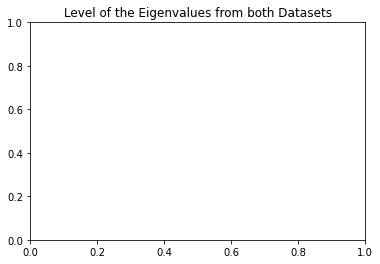

In [12]:
import matplotlib.pyplot as plt

#plt.rcParams['text.usetex'] = True

fig = plt.figure() # open new figure

plt.title("Level of the Eigenvalues from both Datasets")
plt.plot(eval_ex_dB, label="synthetic")
plt.plot(measurement_evals_ex_dB, label="measurement")
plt.ylabel(r'$L_{\lambda_i}$', fontsize=15)
plt.xlabel(r'$i$', fontsize=15)

plt.xticks()
plt.yticks()
plt.legend()

plt.legend()


#plt.show()

#plt.savefig('comparison_synthetic_measurement_data.pdf') 

In [ ]:
print(r'$\latex$')

### Examples of eigenvectors from synthetic dataset 

In [ ]:
last_index = min(main_evecs_dataset.shape[0], noise_evecs_dataset.shape[0])-1

random_index = random.randint(0, last_index)
print(f"index={random_index}")

noise_evec_ex = noise_evecs_dataset[random_index]
main_evec_ex = main_evecs_dataset[random_index]

evec_ex = tf.concat([noise_evec_ex, main_evec_ex],axis=-3)

evec_ex = normalize_evecs(evec_ex)

evec_ex_real = evec_ex[:, :, 0] # get real part from sample
evec_ex_imag = evec_ex[:, :, 1] # get imaginary part from sample


fig = plt.figure(figsize=(15,5))

plt.subplot(1,2,1)
plt.title("Real part")
plt.imshow(np.array(evec_ex_real))
plt.colorbar()

plt.subplot(1,2,2)
plt.title("Imaginary part")
plt.imshow(np.array(evec_ex_imag))
plt.colorbar()

fig.suptitle('Eigenvectors from synthetic dataset', fontsize=16)

### Examples of eigenvectors from measurement dataset

In [ ]:
last_index = min(measurement_main_evecs_dataset.shape[0], measurement_noise_evecs_dataset.shape[0])-1

random_index = random.randint(0, last_index)
print(f"index={random_index}")

noise_evec_ex = measurement_noise_evecs_dataset[random_index]
main_evec_ex = measurement_main_evecs_dataset[random_index]

#print(main_evec_ex)

evec_ex = tf.concat([noise_evec_ex, main_evec_ex],axis=-3)
evec_ex = normalize_evecs(evec_ex)

evec_ex_real = evec_ex[:, :, 0] # get real part from sample
evec_ex_imag = evec_ex[:, :, 1] # get imaginary part from sample

fig = plt.figure(figsize=(15,5))

plt.subplot(1,2,1)
plt.title("Real part")
plt.imshow(np.array(evec_ex_real))
plt.colorbar()

plt.subplot(1,2,2)
plt.title("Imaginary part")
plt.imshow(np.array(evec_ex_imag))
plt.colorbar()

fig.suptitle('Eigenvectors from measurement dataset', fontsize=16)

### Plotting histogram of vectors

In [ ]:
from scipy.stats import norm

# Function for plotting histogram:
def histogram_single_scalar(dataset, decimals=2, vector_index=-1, scalar_index=-1, normalize=False):
    size_measurement  = dataset.shape[0]
    nb_vectors = dataset.shape[1]
    nb_scalar = dataset.shape[2]
    
    if not (vector_index >= 0 and vector_index < nb_vectors):
        vector_index = np.random.randint(nb_vectors)
        print(f"vector_index={vector_index}")
        
    if not (scalar_index >= 0 and scalar_index < nb_scalar):
        scalar_index = np.random.randint(nb_scalar)
        print(f"vector_index={scalar_index}")
    
    resolution = 10**decimals
    bins = np.arange(-resolution,resolution+1, dtype=int)/resolution

    a_real_sum = np.zeros(shape=bins.shape)
    a_imag_sum = np.zeros(shape=bins.shape)

    all_values_real = []
    all_values_imag = []
    

    for i in range(size_measurement):
        a_real = np.round(np.array(dataset[i,vector_index,scalar_index,0]).flatten(), decimals=decimals)
        a_imag = np.round(np.array(dataset[i,vector_index,scalar_index,1]).flatten(), decimals=decimals)
        
        for r, i in zip(np.array(dataset[i,vector_index,scalar_index,0]).flatten(),np.array(dataset[i,vector_index,scalar_index,1]).flatten()):
            all_values_real.append(r)
            all_values_imag.append(i)
            
        a_real_count = np.array([np.sum(a_real == b) for b in bins])
        a_imag_count = np.array([np.sum(a_imag == b) for b in bins])

        a_real_sum = a_real_sum + a_real_count
        a_imag_sum = a_imag_sum + a_imag_count

    fig = plt.figure(figsize=(20,10))
    
    if normalize:
        a_real_sum = a_real_sum/np.max(a_real_sum)
        a_imag_sum = a_imag_sum/np.max(a_imag_sum)
    
    mean_real = np.mean(a_real_sum)
    std_real = np.sqrt(np.var(a_real_sum))
    mean_imag = np.mean(a_imag_sum)
    std_imag = np.sqrt(np.var(a_imag_sum))
    
    print("real values:")
    print(f"- mean: {np.round(mean_real, decimals=2)}")
    print(f"- standard deviation: {np.round(std_real, decimals=2)}")
    print("")
    print("imaginary values:")
    print(f"- mean: {np.round(mean_imag, decimals=2)}")
    print(f"- variance: {np.round(std_imag, decimals=2)}")
    print("")
    
    plt.subplot(1,2,1)
    _ = plt.hist(bins, bins, weights=a_real_sum)

    plt.subplot(1,2,2)
    _ = plt.hist(bins, bins, weights=a_imag_sum)

def histogram_single_vector(dataset, decimals=2, vector_index=-1, normalize=False):
    size_measurement  = dataset.shape[0]
    nb_vectors = dataset.shape[1]
    
    if not (vector_index >= 0 and vector_index < nb_vectors):
        vector_index = np.random.randint(nb_vectors)
        print(f"vector_index={vector_index}")
    
    resolution = 10**decimals
    bins = np.arange(-resolution,resolution+1, dtype=int)/resolution

    a_real_sum = np.zeros(shape=bins.shape)
    a_imag_sum = np.zeros(shape=bins.shape)

    
    all_values_real = []
    all_values_imag = []

    for i in range(size_measurement):
        a_real = np.round(np.array(dataset[i,vector_index,:,0]).flatten(), decimals=decimals)
        a_imag = np.round(np.array(dataset[i,vector_index,:,1]).flatten(), decimals=decimals)

        a_real_count = np.array([np.sum(a_real == b) for b in bins])
        a_imag_count = np.array([np.sum(a_imag == b) for b in bins])

        a_real_sum = a_real_sum + a_real_count
        a_imag_sum = a_imag_sum + a_imag_count
        
        for r, i in zip(np.array(dataset[i,vector_index,:,0]).flatten(),np.array(dataset[i,vector_index,:,1]).flatten()):
            all_values_real.append(r)
            all_values_imag.append(i)

    fig = plt.figure(figsize=(20,10))
    
    if normalize:
        a_real_sum = a_real_sum/np.max(a_real_sum)
        a_imag_sum = a_imag_sum/np.max(a_imag_sum)
    
    print("real values:")
    print(f"- mean: {np.round(np.mean(a_real_sum), decimals=2)}")
    print(f"- variance: {np.round(np.var(a_real_sum), decimals=2)}")
    print("")
    print("imaginary values:")
    print(f"- mean: {np.round(np.mean(a_imag_sum), decimals=2)}")
    print(f"- variance: {np.round(np.var(a_imag_sum), decimals=2)}")
    print("")
    
    plt.subplot(1,2,1)
    _ = plt.hist(bins, bins, weights=a_real_sum)

    plt.subplot(1,2,2)
    _ = plt.hist(bins, bins, weights=a_imag_sum)
    
def histogram_all_vectors(dataset, decimals=2, normalize=False):
    size_measurement  = dataset.shape[0]
    nb_noise_vectors = dataset.shape[1]

    resolution = 10**decimals
    bins = np.arange(-resolution,resolution+1, dtype=int)/resolution

    a_real_sum = np.zeros(shape=bins.shape)
    a_imag_sum = np.zeros(shape=bins.shape)
    
    all_values_real = []
    all_values_imag = []

    for i in range(size_measurement):
        a_real = np.round(np.array(dataset[i,:,:,0]).flatten(), decimals=decimals)
        a_imag = np.round(np.array(dataset[i,:,:,1]).flatten(), decimals=decimals)

        a_real_count = np.array([np.sum(a_real == b) for b in bins])
        a_imag_count = np.array([np.sum(a_imag == b) for b in bins])

        a_real_sum = a_real_sum + a_real_count
        a_imag_sum = a_imag_sum + a_imag_count
        
        for r, i in zip(np.array(dataset[i,:,:,0]).flatten(),np.array(dataset[i,:,:,1]).flatten()):
            all_values_real.append(r)
            all_values_imag.append(i)
        
    if normalize:
        a_real_sum = a_real_sum/np.max(a_real_sum)
        a_imag_sum = a_imag_sum/np.max(a_imag_sum)


    fig = plt.figure(figsize=(20,10))
    
    print("real values:")
    print(f"- mean: {np.round(np.mean(a_real_sum), decimals=2)}")
    print(f"- variance: {np.round(np.var(a_real_sum), decimals=2)}")
    print("")
    print("imaginarysks values:")
    print(f"- mean: {np.round(np.mean(a_imag_sum), decimals=2)}")
    print(f"- variance: {np.round(np.var(a_imag_sum), decimals=2)}")
    print("")
    
    plt.subplot(1,2,1)
    _ = plt.hist(bins, bins, weights=a_real_sum)

    plt.subplot(1,2,2)
    _ = plt.hist(bins, bins, weights=a_imag_sum)
    

vector_index=0
real values:
- mean: 0.1
- variance: 0.06

imaginary values:
- mean: 0.08
- variance: 0.04

vector_index=15
real values:
- mean: 0.11
- variance: 0.07

imaginary values:
- mean: 0.08
- variance: 0.04

vector_index=30
real values:
- mean: 0.11
- variance: 0.07

imaginary values:
- mean: 0.09
- variance: 0.04

vector_index=45
real values:
- mean: 0.11
- variance: 0.07

imaginary values:
- mean: 0.08
- variance: 0.04

vector_index=60
real values:
- mean: 0.09
- variance: 0.04

imaginary values:
- mean: 0.08
- variance: 0.04

vector_index=61
real values:
- mean: 0.08
- variance: 0.04

imaginary values:
- mean: 0.07
- variance: 0.03

vector_index=62
real values:
- mean: 0.05
- variance: 0.02

imaginary values:
- mean: 0.06
- variance: 0.03

vector_index=0
real values:
- mean: 0.07
- variance: 0.03

imaginary values:
- mean: 0.08
- variance: 0.05



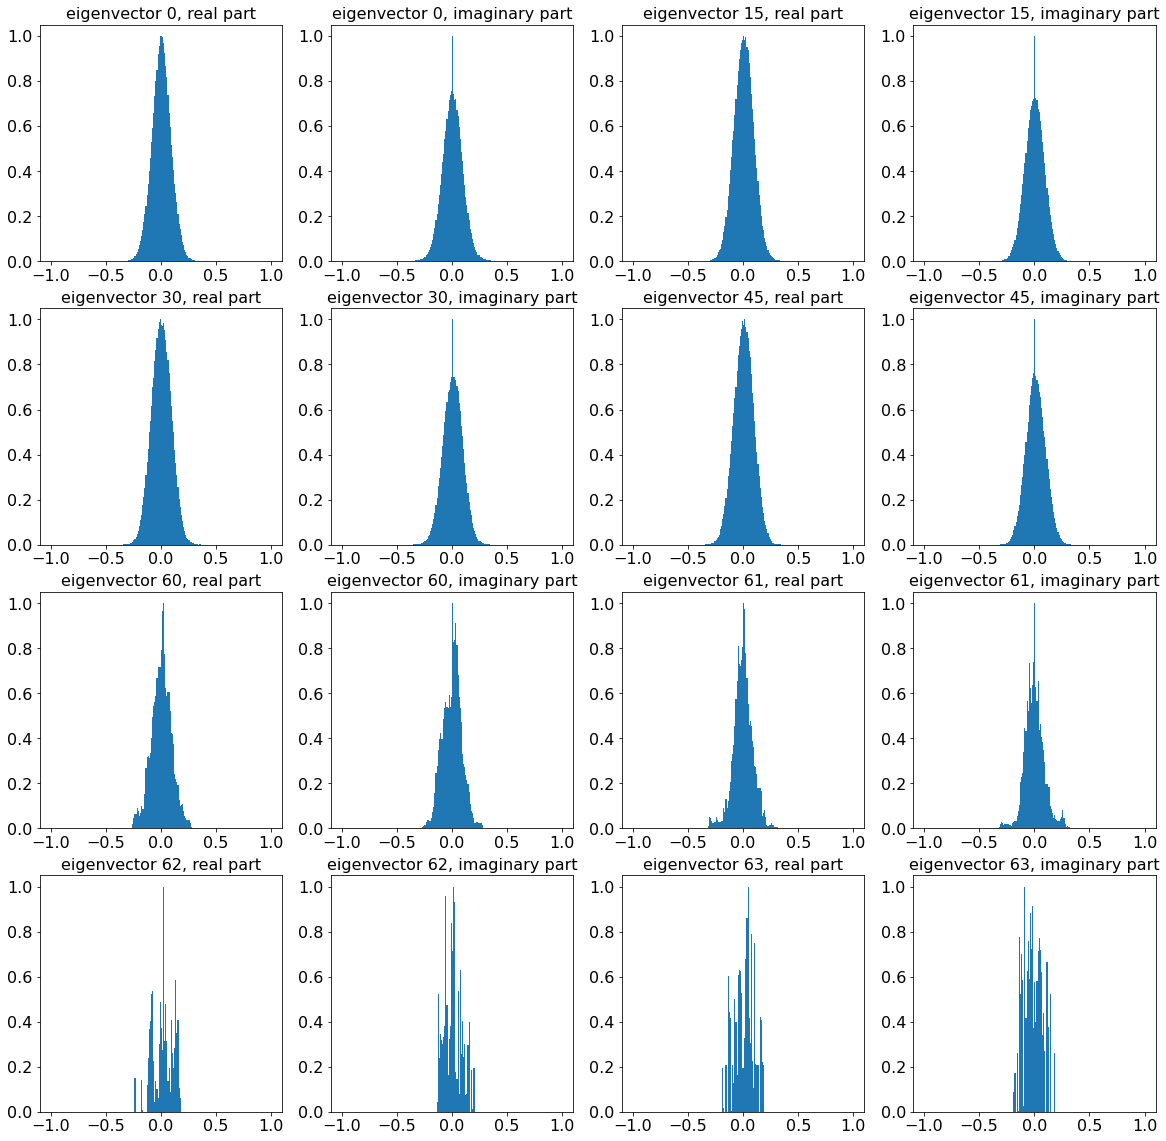

In [11]:
# Cell pour plot les histograms pour le graph

def histogram_single_vector(dataset, decimals=2, vector_index=-1, normalize=False):
    
    size_measurement  = dataset.shape[0]
    nb_vectors = dataset.shape[2]
    
    if not (vector_index >= 0 and vector_index < nb_vectors):
        vector_index = np.random.randint(nb_vectors)
    
    print(f"vector_index={vector_index}")
    
    resolution = 10**decimals
    bins = np.arange(-resolution,resolution+1, dtype=int)/resolution

    a_real_sum = np.zeros(shape=bins.shape)
    a_imag_sum = np.zeros(shape=bins.shape)

    
    all_values_real = []
    all_values_imag = []

    for i in range(size_measurement):
        a_real = np.round(np.array(dataset[i,:,vector_index,0]).flatten(), decimals=decimals)
        a_imag = np.round(np.array(dataset[i,:,vector_index,1]).flatten(), decimals=decimals)

        a_real_count = np.array([np.sum(a_real == b) for b in bins])
        a_imag_count = np.array([np.sum(a_imag == b) for b in bins])

        a_real_sum = a_real_sum + a_real_count
        a_imag_sum = a_imag_sum + a_imag_count
        
        for r, i in zip(np.array(dataset[i,vector_index,:,0]).flatten(),np.array(dataset[i,vector_index,:,1]).flatten()):
            all_values_real.append(r)
            all_values_imag.append(i)
    
    if normalize:
        a_real_sum = a_real_sum/np.max(a_real_sum)
        a_imag_sum = a_imag_sum/np.max(a_imag_sum)
    
    print("real values:")
    print(f"- mean: {np.round(np.mean(a_real_sum), decimals=2)}")
    print(f"- variance: {np.round(np.var(a_real_sum), decimals=2)}")
    print("")
    print("imaginary values:")
    print(f"- mean: {np.round(np.mean(a_imag_sum), decimals=2)}")
    print(f"- variance: {np.round(np.var(a_imag_sum), decimals=2)}")
    print("")
    
    return bins, a_real_sum, a_imag_sum
    
fig = plt.figure(figsize=(20,20))


vector_index =  [0,15,30,45,60,61,62,63]
subplot_index = np.arange(8)

for subplot_i, vector_i in zip(subplot_index, vector_index):
    
    bins, a_real_sum, a_imag_sum = None, None, None
    
    if vector_i == 63:
        bins, a_real_sum, a_imag_sum = histogram_single_vector(measurement_main_evecs_dataset, 
                                                           decimals=2, 
                                                           vector_index=0, 
                                                           normalize=True)   
    else:
        bins, a_real_sum, a_imag_sum = histogram_single_vector(measurement_noise_evecs_dataset, 
                                                           decimals=2, 
                                                           vector_index=vector_i, 
                                                           normalize=True)    
    

    index_real = 2*subplot_i+1
    index_imag = 2*subplot_i+2
    
    size = 16

    plt.subplot(4,4,index_real)
    _ = plt.hist(bins, bins, weights=a_real_sum)
    plt.title(f"eigenvector {vector_i}, real part", fontsize=size)
    plt.xticks(fontsize=size)
    plt.yticks(fontsize=size)
    
    plt.subplot(4,4,index_imag)
    _ = plt.hist(bins, bins, weights=a_imag_sum)
    plt.title(f"eigenvector {vector_i}, imaginary part", fontsize=size)
    plt.xticks(fontsize=size)
    plt.yticks(fontsize=size)

#plt.show()
plt.savefig('histograms_eigenvectors.pdf')

1. Measurement main eigenvector

In [ ]:
histogram_single_vector(measurement_main_evecs_dataset, decimals=2, vector_index=0, normalize=True)

2. Synthetic main eigenvector

In [ ]:
histogram_single_vector(main_evecs_dataset, decimals=2, vector_index=0, normalize=True)

3. All measurement noise eigenvectors

In [ ]:
histogram_all_vectors(measurement_noise_evecs_dataset, decimals=2, normalize=True)

4. All synthetic noise eigenvectors

In [ ]:
histogram_all_vectors(noise_evecs_dataset, decimals=2, normalize=True)

5. Only one measurement noise eigenvector (selected at random)

In [ ]:
histogram_single_vector(measurement_noise_evecs_dataset, decimals=2, vector_index=-1, normalize=True)

6. Only one synthetic noise eigenvector (selected at random)

In [ ]:
histogram_single_vector(noise_evecs_dataset, decimals=2, vector_index=-1, normalize=True)

7. Only one scalar of one single measurement noise eigenvector (selected at random)

In [ ]:
histogram_single_scalar(measurement_noise_evecs_dataset, decimals=2, vector_index=-1, scalar_index=-1, normalize=True)

8. Only one scalar of one single synthetic noise eigenvector (selected at random)

In [ ]:
histogram_single_scalar(noise_evecs_dataset, decimals=2, vector_index=-1, scalar_index=-1, normalize=True)

### Beamforming example: synthetic dataset

In [ ]:
last_index = min(min(main_evecs_dataset.shape[0], noise_evecs_dataset.shape[0]), evals_dataset.shape[0])-1
random_index = random.randint(0, last_index)
print(f"index={random_index}")


evals_ex = evals_dataset[random_index]
noise_evecs_ex = noise_evecs_dataset[random_index]
main_evecs_ex = main_evecs_dataset[random_index]
evecs_ex = tf.concat([noise_evecs_ex, main_evecs_ex], axis=-3)

# Normalizing
evals_ex  = normalize_evals(evals_ex)
evecs_ex  = normalize_evecs(evecs_ex)

# reshape data
evals_vec_numpy = np.sort(np.array(evals_ex[:, :, 0]).flatten())
evals_vec = tf.convert_to_tensor(evals_vec_numpy)
evecs_real = evecs_ex[:, :, 0] # get real part from sample
evecs_imag = evecs_ex[:, :, 1] # get imaginary part from sample

csm = get_csm(evecs_real, evecs_imag, evals_vec).numpy()

NUMFREQ = 1 
NUMCHANNELS = 64

csm = np.reshape(csm, newshape=(NUMFREQ,NUMCHANNELS,NUMCHANNELS))

beamform(csm, helmotz_number=HELMOTZ_NUMBER_SYNTHETIC, measurement=False)

### Beamforming example: measurement set

In [ ]:
last_index = min(min(measurement_main_evecs_dataset.shape[0], measurement_noise_evecs_dataset.shape[0]), measurement_evals_dataset.shape[0])-1
random_index = random.randint(0, last_index)
print(f"index={random_index}")


evals_ex = measurement_evals_dataset[random_index]
noise_evecs_ex = measurement_noise_evecs_dataset[random_index]
main_evecs_ex = measurement_main_evecs_dataset[random_index]
evecs_ex = tf.concat([noise_evecs_ex, main_evecs_ex], axis=-3)

# Normalizing
evals_ex  = normalize_evals(evals_ex)
evecs_ex  = normalize_evecs(evecs_ex)

# reshape data
evals_vec_numpy = np.sort(np.array(evals_ex[:, :, 0]).flatten())
evals_vec = tf.convert_to_tensor(evals_vec_numpy)
evecs_real = evecs_ex[:, :, 0] # get real part from sample
evecs_imag = evecs_ex[:, :, 1] # get imaginary part from sample

csm = get_csm(evecs_real, evecs_imag, evals_vec).numpy()

NUMFREQ = 1 # one freq with index bin = 13 ? -> is that accurate ?
NUMCHANNELS = 64

csm = np.reshape(csm, newshape=(NUMFREQ,NUMCHANNELS,NUMCHANNELS))

beamform(csm, helmotz_number=HELMOTZ_NUMBER_MEASUREMENT, measurement=True)

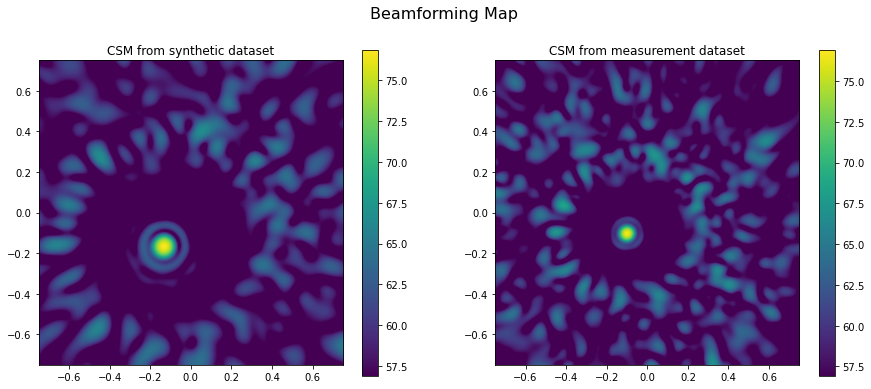

In [16]:
# Beamforming example datasets

NUMFREQ = 1 # one freq with index bin = 13 ? -> is that accurate ?
NUMCHANNELS = 64

# Synthetic ===================================================

evals_ex = evals_dataset[0]
noise_evecs_ex = noise_evecs_dataset[0]
main_evecs_ex = main_evecs_dataset[0]
evecs_ex = tf.concat([noise_evecs_ex, main_evecs_ex], axis=-2)

# Normalizing
evals_ex  = normalize_evals(evals_ex)
evecs_ex  = normalize_evecs(evecs_ex)

# reshape data
evals_vec_numpy = np.sort(np.array(evals_ex[:, :, 0]).flatten())
evals_vec = tf.convert_to_tensor(evals_vec_numpy)
evecs_real = evecs_ex[:, :, 0] # get real part from sample
evecs_imag = evecs_ex[:, :, 1] # get imaginary part from sample

synthetic_csm = get_csm(evecs_real, evecs_imag, evals_vec).numpy()
synthetic_csm = np.reshape(synthetic_csm, newshape=(NUMFREQ,NUMCHANNELS,NUMCHANNELS))

# Measurement ===================================================

evals_ex = measurement_evals_dataset[0]
noise_evecs_ex = measurement_noise_evecs_dataset[0]
main_evecs_ex = measurement_main_evecs_dataset[0]
evecs_ex = tf.concat([noise_evecs_ex, main_evecs_ex], axis=-2)

# Normalizing
evals_ex  = normalize_evals(evals_ex)
evecs_ex  = normalize_evecs(evecs_ex)

# reshape data
evals_vec_numpy = np.sort(np.array(evals_ex[:, :, 0]).flatten())
evals_vec = tf.convert_to_tensor(evals_vec_numpy)
evecs_real = evecs_ex[:, :, 0] # get real part from sample
evecs_imag = evecs_ex[:, :, 1] # get imaginary part from sample

measurement_csm = get_csm(evecs_real, evecs_imag, evals_vec).numpy()
measurement_csm = np.reshape(measurement_csm, newshape=(NUMFREQ,NUMCHANNELS,NUMCHANNELS))

# Plotting the beamforming map

fig = plt.figure(figsize=(15,6))

plt.subplot(121)
plt.title("CSM from synthetic dataset")
beamform(synthetic_csm, helmotz_number=HELMOTZ_NUMBER_SYNTHETIC, measurement=True)


plt.subplot(122)
plt.title("CSM from measurement dataset")
beamform(measurement_csm, helmotz_number=HELMOTZ_NUMBER_MEASUREMENT, measurement=True)

fig.suptitle('Beamforming Map', fontsize=16)

plt.savefig("datasets_beamforming_example.pdf")


# Generating data
### Generating eigenvalues from regular values
First step is creating the Wasserstein GAN and training it with synthetic data

In [ ]:
# Generating eigenvalues

# Creating GAN
evals_wgangp = evals_WGANGP()

# Compiling GAN
evals_wgangp.compile()

# Getting directories for callbacks
filename = "evals_wgangp_" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S") 
log_dir = f"logs/{filename}"
checkpoint_dir = f"checkpoints/{filename}"

# Creating callbacks
tensorboard_callback = tf.keras.callbacks.TensorBoard(
                                                    log_dir=log_dir,
                                                    histogram_freq=1
                                                    )
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
                                                    filepath=checkpoint_dir,
                                                    save_weights_only=True,
                                                    monitor='c_loss',
                                                    mode='min',
                                                    save_best_only=True
                                                    )

# Training GAN
history = evals_wgangp.fit(
    evals_dataset,
    batch_size=BATCH_SIZE,
    epochs=100,
    steps_per_epoch=1,
    callbacks=[tensorboard_callback, checkpoint_callback]
)



plot_loss(history)

# time for epoch=100, step=5, batch_size=16 -> approx 18min.
# time for epoch=100, step=10, batch_size=16 -> approx 32min.
# time for epoch=100, step=20, batch_size=16 -> approx _min.

In [ ]:
# Generating fake sample (before fine-tuning)
_, evals = evals_wgangp.generate_evals(nb_trial=10)

evals = np.sort(np.array(evals[0, :, :, 0]).flatten()) # convert sample from (1,8,8,1) to (64,)
evals_dB = levelify(evals)


The second step is to train further the Wassertin GAN using this time really measurement

In [ ]:
history = evals_wgangp.fit(
    measurement_evals_dataset,
    batch_size=BATCH_SIZE,
    epochs=200,
    steps_per_epoch=5,
    #callbacks=[tensorboard_callback, checkpoint_callback]
)

plot_loss(history)

Finally the obtained samples can be plotted

In [ ]:
# Creating and plotting fake sample after fine-tuning

# Getting data from dataset
random_index = random.randint(0, evals_dataset.shape[0]-1)
print(f"index={random_index}")

eval_ex = normalize_evals(evals_dataset[random_index])
eval_ex = np.sort(np.array(eval_ex[:, :, 0]).flatten())
eval_ex_dB = levelify(eval_ex)

# Example:
random_index = random.randint(0, measurement_evals_dataset.shape[0]-1)
print(f"index={random_index}")
measurement_evals_ex = measurement_evals_dataset[random_index]

measurement_evals_ex = normalize_evals(measurement_evals_ex)
measurement_evals_ex = np.sort(np.array(measurement_evals_ex[:, :, 0]).flatten())
measurement_evals_ex_dB = levelify(measurement_evals_ex)




_, meas_evals = evals_wgangp.generate_evals(nb_trial=10)

meas_evals = np.sort(np.array(meas_evals[0, :, :, 0]).flatten()) # convert sample from (1,8,8,1) to (64,)
meas_evals_dB = levelify(meas_evals)



In [ ]:
# plot both

fig = plt.figure(figsize=(15,5))

plt.subplot(1,2,1)
plt.title("Normalized value")
plt.plot(evals, label="generated before fine-tuning")
plt.plot(meas_evals, label="generated after fine-tuning")
plt.plot(eval_ex, label="synthetic data")
plt.plot(measurement_evals_ex, label="measured data")
plt.legend()


plt.subplot(1,2,2)
plt.title("in dB")
plt.plot(evals_dB, label="generated before fine-tuning")
plt.plot(meas_evals_dB, label="generated after fine-tuning")
plt.plot(eval_ex_dB, label="synthetic data")
plt.plot(measurement_evals_ex_dB, label="measured data")
plt.legend()

fig.suptitle('Eigenvalues', fontsize=16)

In [ ]:
# only plot normal values 

fig = plt.figure(figsize=(15,10))

title_fontsize = 20
axis_fontsize = 17
nb_fontsize = 15
legend_fontsize = 15


fig = plt.figure(figsize=(15,5))

plt
plt.title("Eigenvalues: Normalized value before fine-tuning", fontsize=title_fontsize)
plt.plot(evals, label="generated before fine-tuning")
#plt.plot(meas_evals, label="generated after fine-tuning")
plt.plot(eval_ex, label="synthetic data")
#plt.plot(measurement_evals_ex, label="measured data")
plt.ylabel('normalized value', fontsize=axis_fontsize)
plt.xlabel('eigenvalue index', fontsize=axis_fontsize)
plt.xticks(fontsize=nb_fontsize)
plt.yticks(fontsize=nb_fontsize)
plt.legend(fontsize=legend_fontsize)

plt.show()

In [ ]:
# only plot normal values 

fig = plt.figure(figsize=(15,10))

title_fontsize = 20
axis_fontsize = 17
nb_fontsize = 15
legend_fontsize = 15

plt.title("Eigenvalues: level values", fontsize=title_fontsize)
plt.plot(evals_dB, label="generated before fine-tuning")
plt.plot(meas_evals_dB, label="generated after fine-tuning")
plt.plot(eval_ex_dB, label="synthetic data")
plt.plot(measurement_evals_ex_dB, label="measured data")
plt.ylabel('level value [dB]', fontsize=axis_fontsize)
plt.xlabel('eigenvalue index', fontsize=axis_fontsize)
plt.xticks(fontsize=nb_fontsize)
plt.yticks(fontsize=nb_fontsize)
plt.legend(fontsize=legend_fontsize)

plt.show()

### Generating eigenvalues from level values (i.e. [dB] values)
First step is creating the Wasserstein GAN and training it with synthetic data

In [ ]:
# First plot data about to be fed:
plt.plot(np.array(evals_dB_dataset[0,:,:,0]).flatten())

In [ ]:
# Generating eigenvalues

# Creating GAN
evals_dB_wgangp = evals_dB_WGANGP()

# Compiling GAN
evals_dB_wgangp.compile()

# Getting directories for callbacks
filename = "evals_dB_wgangp" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S") 
log_dir = f"logs/{filename}"
checkpoint_dir = f"checkpoints/{filename}"

# Creating callbacks
tensorboard_callback = tf.keras.callbacks.TensorBoard(
                                                    log_dir=log_dir,
                                                    histogram_freq=1
                                                    )

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
                                                    filepath=checkpoint_dir,
                                                    save_weights_only=True,
                                                    monitor='g_loss',
                                                    mode='min',
                                                    save_best_only=True
                                                    )


inverse_evals_dB_dataset = -1*evals_dB_dataset 
# Training GAN
history = evals_dB_wgangp.fit(
    evals_dB_dataset,
    batch_size=BATCH_SIZE,
    epochs=100,
    steps_per_epoch=1,
    callbacks=[tensorboard_callback, checkpoint_callback]
)

plot_loss(history)



In [ ]:
# Generating fake sample (before fine-tuning)

_, bft_evals_dB = evals_dB_wgangp.generate_evals(nb_trial=10)

bft_evals_dB = np.array(bft_evals_dB[0, :, :, 0]).flatten() # convert sample from (1,8,8,1) to (64,)
bft_evals = unlevelify(bft_evals_dB)

In [ ]:
plt.plot(bft_evals_dB, label="synthetic data")
plt.plot(np.array(evals_dB_dataset[0,:,:,0]).flatten(), label="generated before fine-tuning")
plt.legend()

In [ ]:
plt.plot(bft_evals, label="generated before fine-tuning")
plt.plot(10**np.array(evals_dB_dataset[0,:,:,0]).flatten(), label="synthetic data")
plt.legend()

The second step is to train further the Wasserstein GAN using this time really measurement

In [ ]:
# Creating GAN
#evals_dB_wgangp = evals_dB_WGANGP()

# Compiling GAN
#evals_dB_wgangp.compile()

history = evals_dB_wgangp.fit(
    measurement_evals_dB_dataset,
    batch_size=BATCH_SIZE,
    epochs=120,
    steps_per_epoch=1,
    #callbacks=[tensorboard_callback, checkpoint_callback]
)

plot_loss(history)

Finally the obtained samples can be plotted

In [ ]:
# Creating and plotting fake sample after fine-tuning

# Getting data from dataset
random_index = random.randint(0, evals_dataset.shape[0]-1)
print(f"index={random_index}")

evals_ex = normalize_evals(evals_dataset[random_index])
evals_ex = np.sort(np.array(evals_ex[:, :, 0]).flatten())
evals_ex_dB = levelify(evals_ex)

# Example:
random_index = random.randint(0, measurement_evals_dataset.shape[0]-1)
print(f"index={random_index}")
measurement_evals_ex = measurement_evals_dataset[random_index]

measurement_evals_ex = normalize_evals(measurement_evals_ex)
measurement_evals_ex = np.sort(np.array(measurement_evals_ex[:, :, 0]).flatten())
measurement_evals_ex_dB = levelify(measurement_evals_ex)




_, aft_evals_dB = evals_dB_wgangp.generate_evals(nb_trial=10)

aft_evals_dB = np.sort(np.array(aft_evals_dB[0, :, :, 0]).flatten()) # convert sample from (1,8,8,1) to (64,)
aft_evals = unlevelify(aft_evals_dB)

fig = plt.figure(figsize=(15,5))

plt.subplot(1,2,2)
plt.title("Normalized value")
plt.plot(bft_evals, label="generated before fine-tuning")
plt.plot(aft_evals, label="generated after fine-tuning")
plt.plot(evals_ex, label="synthetic data")
plt.plot(measurement_evals_ex, label="measured data")
plt.legend()


plt.subplot(1,2,1)
plt.title("in dB")
plt.plot(bft_evals_dB, label="generated before fine-tuning")
plt.plot(aft_evals_dB, label="generated after fine-tuning")
plt.plot(evals_ex_dB, label="synthetic data")
plt.plot(measurement_evals_ex_dB, label="measured data")
plt.legend()

fig.suptitle('Eigenvalues', fontsize=16)

In [ ]:
fig = plt.figure(figsize=(15,10))

title_fontsize = 20
axis_fontsize = 17
nb_fontsize = 15
legend_fontsize = 15


_, aft_evals_dB = evals_dB_wgangp.generate_evals(nb_trial=10)
aft_evals_dB = np.sort(np.array(aft_evals_dB[0, :, :, 0]).flatten()) # convert sample from (1,8,8,1) to (64,)


plt.title("Eigenvalues: level values after fine-tuning", fontsize=title_fontsize)
plt.plot(measurement_evals_ex_dB, label="measured data")
plt.plot(aft_evals_dB, label="generated after fine-tuning")
plt.ylabel('level value [dB]', fontsize=axis_fontsize)
plt.xlabel('eigenvalue index', fontsize=axis_fontsize)

plt.xticks(fontsize=nb_fontsize)
plt.yticks(fontsize=nb_fontsize)
plt.legend(fontsize=legend_fontsize)
    
plt.show()

In [ ]:
fig = plt.figure(figsize=(15,10))

title_fontsize = 20
axis_fontsize = 17
nb_fontsize = 15
legend_fontsize = 15



plt.title("Eigenvalues: level values before fine-tuning", fontsize=title_fontsize)
plt.plot(evals_ex_dB, label="synthetic data")
plt.plot(bft_evals_dB, label="generated before fine-tuning")
plt.ylabel('level value [dB]', fontsize=axis_fontsize)
plt.xlabel('eigenvalue index', fontsize=axis_fontsize)

plt.xticks(fontsize=nb_fontsize)
plt.yticks(fontsize=nb_fontsize)
plt.legend(fontsize=legend_fontsize)
    
plt.show()

In [ ]:
"""




plt.title("Eigenvalues: level values before fine-tuning", )
plt.plot(evals_ex_dB, label="synthetic data")
plt.plot(bft_evals_dB, label="generated before fine-tuning")
plt.ylabel('level value [dB]', fontsize=axis_fontsize)
plt.xlabel('eigenvalue index', fontsize=axis_fontsize)

plt.xticks(fontsize=nb_fontsize)
plt.yticks(fontsize=nb_fontsize)
plt.legend(fontsize=legend_fontsize)
    
plt.show()
"""

fig = plt.figure(figsize=(15,10))

title_fontsize = 20
axis_fontsize = 17
nb_fontsize = 15
legend_fontsize = 15



plt.title("Eigenvalues: Normalized value", fontsize=title_fontsize)
plt.plot(unlevelify(bft_evals_dB), label="generated before fine-tuning")
plt.plot(unlevelify(aft_evals_dB), label="generated after fine-tuning")
plt.plot(evals_ex, label="synthetic data")
plt.plot(measurement_evals_ex, label="measured data")

plt.ylabel('value', fontsize=axis_fontsize)
plt.xlabel('eigenvalue index', fontsize=axis_fontsize)

plt.xticks(fontsize=nb_fontsize)
plt.yticks(fontsize=nb_fontsize)
plt.legend(fontsize=legend_fontsize)
    
plt.show()

In [ ]:
# test

a = np.concatenate(([-40], aft_evals_dB[0:63]))

plt.plot(measurement_evals_ex_dB, label="measured data")
plt.plot(a, label="shifted generated after fine-tuning")
plt.legend()

In [ ]:
# test

a = np.concatenate(([-40], aft_evals_dB[0:63]))
print(a)
print(10**a)
plt.plot(measurement_evals_ex, label="measured data")
plt.plot(10**a, label="shifted generated after fine-tuning")
plt.legend()

In [ ]:



plt.plot(measurement_evals_ex, label="measured data")
plt.plot(aft_evals, label="generated after fine-tuning")
plt.legend()

### Generating main Eigenvectors

In [ ]:
# Generating main component of eigenvectors

# Creating GAN
main_evecs_wgangp = main_evecs_WGANGP()

# Compiling GAN
main_evecs_wgangp.compile()

# Getting directories for callbacks
filename = "main_evecs_wgangp_" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S") 
log_dir = f"logs/{filename}"
checkpoint_dir = f"checkpoints/{filename}"

# Creating callbacks
tensorboard_callback = tf.keras.callbacks.TensorBoard(
                                                    log_dir=log_dir,
                                                    histogram_freq=1
                                                    )
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
                                                    filepath=checkpoint_dir,
                                                    save_weights_only=True,
                                                    monitor='g_loss',
                                                    mode='min',
                                                    save_best_only=True
                                                    )


# Training GAN
history = main_evecs_wgangp.fit(
    main_evecs_dataset,
    batch_size=BATCH_SIZE,
    epochs=500,
    steps_per_epoch=1,
    callbacks=[tensorboard_callback, checkpoint_callback]
)

plot_loss(history)
# time for epoch=100, step=1, batch_size=16 -> approx 15min.

In [ ]:
_, main_evecs = main_evecs_wgangp.generate_evecs(nb_trial=10)

main_evecs_real = main_evecs[0, :, :, 0] # get real part from sample
main_evecs_imag = main_evecs[0, :, :, 1] # get imaginary part from sample


fig = plt.figure(figsize=(15,5))

plt.subplot(1,2,1)
plt.title("Real part")
plt.imshow(main_evecs_real)
plt.colorbar()

plt.subplot(1,2,2)
plt.title("Imaginary part")
plt.imshow(main_evecs_imag)
plt.colorbar()

fig.suptitle('Eigenvectors before fine-tuning', fontsize=16) 

In [ ]:
# fine-tuning
history = main_evecs_wgangp.fit(
    measurement_main_evecs_dataset,
    batch_size=BATCH_SIZE,
    epochs=NB_MEASUREMENT_BATCH,
    steps_per_epoch=1,
    callbacks=[tensorboard_callback, checkpoint_callback]
)

plot_loss(history)

In [ ]:
_, main_evecs_after = main_evecs_wgangp.generate_evecs(nb_trial=10)

main_evecs_real_after = main_evecs_after[0, :, :, 0] # get real part from sample
main_evecs_imag_after = main_evecs_after[0, :, :, 1] # get imaginary part from sample


fig = plt.figure(figsize=(15,5))

plt.subplot(1,2,1)
plt.title("Real part")
plt.imshow(main_evecs_real_after)
plt.colorbar()

plt.subplot(1,2,2)
plt.title("Imaginary part")
plt.imshow(main_evecs_imag_after)
plt.colorbar()

fig.suptitle('Eigenvectors after fine-tuning', fontsize=16) 

### Generating Eigenvectors (main+noise) 

Training on synthetic data

In [ ]:
# Generating main component of eigenvectors

# Creating GAN
main_evecs_wgangp = main_evecs_WGANGP()

# Compiling GAN
main_evecs_wgangp.compile()

# Getting directories for callbacks
filename = "main_evecs_wgangp_" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S") 
log_dir = f"logs/{filename}"
checkpoint_dir = f"checkpoints/{filename}"

# Creating callbacks
tensorboard_callback = tf.keras.callbacks.TensorBoard(
                                                    log_dir=log_dir,
                                                    histogram_freq=1
                                                    )
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
                                                    filepath=checkpoint_dir,
                                                    save_weights_only=True,
                                                    monitor='g_loss',
                                                    mode='min',
                                                    save_best_only=True
                                                    )


# Training GAN
main_evecs_wgangp.fit(
    main_evecs_dataset,
    batch_size=BATCH_SIZE,
    epochs=NB_SYNTHETIC_BATCH,
    steps_per_epoch=NB_STEPS,
    callbacks=[tensorboard_callback, checkpoint_callback]
)
# time for epoch=100, step=1, batch_size=16 -> approx 15min.

In [ ]:
# Generating noise component of eigenvectors

# Creating GAN
latent_dim = 2048
n_crit = 7
noise_evecs_wgangp = noise_evecs_WGANGP(latent_dim=latent_dim, critic_extra_steps=n_crit)

# Compiling GAN
noise_evecs_wgangp.compile()

# Getting directories for callbacks
filename = f"noise_evecs_wgangp_latent={latent_dim}_n_crit={n_crit}" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S") 
log_dir = f"logs/{filename}"
checkpoint_dir = f"checkpoints/{filename}"

# Creating callbacks
tensorboard_callback = tf.keras.callbacks.TensorBoard(
                                                    log_dir=log_dir,
                                                    histogram_freq=1
                                                    )
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
                                                    filepath=checkpoint_dir,
                                                    save_weights_only=True,
                                                    monitor='g_loss',
                                                    mode='min',
                                                    save_best_only=True
                                                    )




# Training GAN
noise_evecs_wgangp.fit(
    noise_evecs_dataset,
    batch_size=BATCH_SIZE,
    epochs=500,
    steps_per_epoch=1000,
    callbacks=[tensorboard_callback, checkpoint_callback]
)

Generating eigenvectors before fine-tuning

In [ ]:
# Creating and plotting fake sample

_, noise_evecs = noise_evecs_wgangp.generate_evecs(nb_trial=10)
_, main_evecs = main_evecs_wgangp.generate_evecs(nb_trial=10)

evecs = tf.concat([noise_evecs, main_evecs],axis=-3)


evecs_real = evecs[0, :, :, 0] # get real part from sample
evecs_imag = evecs[0, :, :, 1] # get imaginary part from sample


fig = plt.figure(figsize=(15,5))

plt.subplot(1,2,1)
plt.title("Real part")
plt.imshow(evecs_real)
plt.colorbar()

plt.subplot(1,2,2)
plt.title("Imaginary part")
plt.imshow(evecs_imag)
plt.colorbar()

fig.suptitle('Eigenvectors', fontsize=16)

Fine-tuning with measurements

In [ ]:
# main
print("training WGAN-GP for generating main eigenvector")
print("")
main_evecs_wgangp.fit(
    measurement_main_evecs_dataset,
    batch_size=BATCH_SIZE,
    epochs=NB_MEASUREMENT_BATCH,
    steps_per_epoch=NB_STEPS,
    callbacks=[tensorboard_callback, checkpoint_callback]
)
print("")
print("")
print("training WGAN-GP for generating noise eigenvectors")
print("")
# noise
"""
noise_evecs_wgangp.fit(
    measurement_noise_evecs_dataset,
    batch_size=BATCH_SIZE,
    epochs=NB_MEASUREMENT_BATCH,
    steps_per_epoch=NB_STEPS,
    callbacks=[tensorboard_callback, checkpoint_callback]
)
"""

Plotting Eigenvectors (after fine-tuning) 

In [ ]:
_, noise_evecs = noise_evecs_wgangp.generate_evecs(nb_trial=10)
_, main_evecs = main_evecs_wgangp.generate_evecs(nb_trial=10)

evecs = tf.concat([noise_evecs, main_evecs],axis=-3)


evecs_real = evecs[0, :, :, 0] # get real part from sample
evecs_imag = evecs[0, :, :, 1] # get imaginary part from sample


fig = plt.figure(figsize=(15,5))

plt.subplot(1,2,1)
plt.title("Real part")
plt.imshow(evecs_real)
plt.colorbar()

plt.subplot(1,2,2)
plt.title("Imaginary part")
plt.imshow(evecs_imag)
plt.colorbar()

fig.suptitle('Eigenvectors', fontsize=16)

# Performing beamforming on fully generated data
1. Using a full CSM

In [ ]:
from beamforming import beamform, get_csm

_, generated_evals = evals_wgangp.generate_evals(nb_trial=10)
_, generated_noise_evecs = noise_evecs_wgangp.generate_evecs(nb_trial=10)
_, generated_main_evecs = main_evecs_wgangp.generate_evecs(nb_trial=10)

generated_evecs = tf.concat([generated_noise_evecs, generated_main_evecs], axis=-3)

# reshape data
evals_vec_numpy = np.sort(np.array(generated_evals[0, :, :, 0]).flatten())
evals_vec = tf.convert_to_tensor(evals_vec_numpy)
#evecs_real = generated_evecs[0, :, :, 0] # get real part from sample
#evecs_imag = generated_evecs[0, :, :, 1] # get imaginary part from sample
evecs_real = generated_evecs[ :, :, 0] #TODO: delete
evecs_imag = generated_evecs[ :, :, 1] #TODO: delete


csm = get_csm(evecs_real, evecs_imag, evals_vec).numpy()

NUMFREQ = 1 # one freq with index bin = 13 ? -> is that accurate ?
NUMCHANNELS = 64

csm = np.reshape(csm, newshape=(NUMFREQ,NUMCHANNELS,NUMCHANNELS))

beamform(csm)

2. Using a Rank I CSM

In [ ]:
def get_rank_I_csm(main_evec_real, main_evec_imag, evals_vec):

    main_evec = tf.complex(main_evec_real, main_evec_imag)
    """main_evec = main_evec[:,tf.newaxis]
    print(f"main_evec.shape{main_evec.shape}")
    main_evec_H = tf.linalg.adjoint(main_evec)
    print(f"main_evec_H.shape{main_evec_H.shape}")"""
    
    main_evec_conj = tf.math.conj(main_evec) 
    
    # reshaping eigenvalues
    mask = np.zeros(shape=evals_vec.shape, dtype='float32')
    mask[0] = 1
    mask = tf.convert_to_tensor(mask)    
    main_evals_vec = tf.math.multiply(evals_vec, mask)
    evals_real = tf.linalg.diag(main_evals_vec)
    evals_imag = tf.zeros(shape=evals_real.shape) # because evals also need to be complex to be multiplied with complex matrix
    evals = tf.complex(evals_real, evals_imag)
    
    # performing the multiplication
    #tmp_mult = tf.linalg.matmul(main_evec,evals)
    #full_mult = tf.linalg.matmul(tmp_mult,main_evec_H)
    
    full_mult = tf.einsum('i, jk, l -> il',  main_evec, evals, main_evec_conj)
    
    #print(tmp_mult.shape)
    print(full_mult.shape)
    return full_mult
    

In [ ]:
from beamforming import beamform, get_csm

_, generated_evals = evals_wgangp.generate_evals(nb_trial=10)
_, generated_main_evec = main_evecs_wgangp.generate_evecs(nb_trial=10)

# reshape data
evals_vec_numpy = np.sort(np.array(generated_evals[0, :, :, 0]).flatten())
evals_vec = tf.convert_to_tensor(evals_vec_numpy)
main_evec_real = generated_main_evec[0,0, :, 0] 
main_evec_imag = generated_main_evec[0,0, :, 1]

rank_I_csm = get_rank_I_csm(main_evec_real, main_evec_imag, evals_vec).numpy()

NUMFREQ = 1 # one freq with index bin = 13 ? -> is that accurate ?
NUMCHANNELS = 64

rank_I_csm = np.reshape(rank_I_csm, newshape=(NUMFREQ,NUMCHANNELS,NUMCHANNELS))

beamform(rank_I_csm)

In [ ]:
# test: synthetic data
from beamforming import beamform, get_csm

max_value = min(evals_dataset.shape[0],main_evecs_dataset.shape[0]) 
index = np.random.randint(0, max_value)
print(f"index={index}")

generated_evals = evals_dataset[index, :, :,:]
generated_main_evec = main_evecs_dataset[index, :, :,:]

"""
generated_evals = measurement_evals_dataset[index, :, :,:]
generated_main_evec = measurement_main_evecs_dataset[index, :, :,:]
"""

# reshape data
evals_vec_numpy = np.sort(np.array(generated_evals[ :, :, 0]).flatten())
evals_vec = tf.convert_to_tensor(evals_vec_numpy)
main_evec_real = generated_main_evec[0, :, 0] 
main_evec_imag = generated_main_evec[0, :, 1]

rank_I_csm = get_rank_I_csm(main_evec_real, main_evec_imag, evals_vec).numpy()

NUMFREQ = 1 # one freq with index bin = 13 ? -> is that accurate ?
NUMCHANNELS = 64

rank_I_csm = np.reshape(rank_I_csm, newshape=(NUMFREQ,NUMCHANNELS,NUMCHANNELS))

beamform(rank_I_csm, helmotz_number=HELMOTZ_NUMBER_SYNTHETIC, measurement=False)

In [ ]:
# test: measurement data
from beamforming import beamform, get_csm


max_value = min(measurement_evals_dataset.shape[0],measurement_main_evecs_dataset.shape[0]) 
index = np.random.randint(0, max_value)
print(f"index={index}")


generated_evals = measurement_evals_dataset[index, :, :,:]
generated_main_evec = measurement_main_evecs_dataset[index, :, :,:]

# reshape data
evals_vec_numpy = np.sort(np.array(generated_evals[ :, :, 0]).flatten())
evals_vec = tf.convert_to_tensor(evals_vec_numpy)
main_evec_real = generated_main_evec[0, :, 0] 
main_evec_imag = generated_main_evec[0, :, 1]

rank_I_csm = get_rank_I_csm(main_evec_real, main_evec_imag, evals_vec).numpy()

NUMFREQ = 1 # one freq with index bin = 13 ? -> is that accurate ?
NUMCHANNELS = 64

rank_I_csm = np.reshape(rank_I_csm, newshape=(NUMFREQ,NUMCHANNELS,NUMCHANNELS))

beamform(rank_I_csm, helmotz_number=HELMOTZ_NUMBER_MEASUREMENT, measurement=True)

# Data augmentation

In [ ]:
from data_augmentation import get_augmentented_dataset

evecs_subdataset = evecs_dataset[:1,:,:,:]

augmented_sample_dataset = get_augmentented_dataset(
                            evals_dataset=evals_dataset,
                            batch_size=BATCH_SIZE,
                            nb_batch=NB_BATCH,
                            steps_per_epoch=NB_STEPS,
                            evecs_dataset=evecs_subdataset,
                            size_augmentation=10
                            )

augmented_evecs_dataset = tf.convert_to_tensor([s[0] for s in augmented_sample_dataset])
augmented_evals_dataset = tf.convert_to_tensor([s[1] for s in augmented_sample_dataset])

In [ ]:
print(augmented_evals_dataset.shape)
print(augmented_evecs_dataset.shape)

In [ ]:
from beamforming import beamform, get_csm

NUMFREQ = 1
NUMCHANNELS = 64

augmented_evals = augmented_evals_dataset[0,:,:,:]
augmented_evecs = augmented_evecs_dataset[0,:,:,:]

evals_vec_numpy = np.sort(np.array(augmented_evals[0,:, :, 0]).flatten())
evals_vec = tf.convert_to_tensor(evals_vec_numpy) 

evecs_real = augmented_evecs[:,:,0]
evecs_imag = augmented_evecs[:,:,1]

csm = get_csm(evecs_real, evecs_imag, evals_vec).numpy()
csm = np.reshape(csm, newshape=(NUMFREQ,NUMCHANNELS,NUMCHANNELS))

beamform(csm)

# Everything below is outdated

===================================================================================================

### Opening real measurement

from mail: Note that the files stem from two different measurements with different loudspeakers (see pictures). In one case, the samplerate is 25.6 kHz and in the other case it is 51.2 kHz. Each measurement was performed for 10 seconds.

Currently, the measured data only include 51 different source cases. You can augment the dataset by simply using different time sections from each measurement to calculate the CSM (or/and by varying parameters such as the block size, window, and overlap).

about the samples:
- length: 10s
- sample rate: either 25.6 kHz or 51.2 kHz
- position: always different (51 different position)
- format: .h5

In [ ]:
"""
from measurement import get_measurement_batch
import tensorflow as tf
from eigenmanipulation import normalize_evals
import random
import matplotlib.pyplot as plt

measurement_path = "../Data/Measurement/td/"
measurement_path_c4 = "../../../shared/measured_data/td/"
filename = "2021-03-19_14-28-01_611275.h5"

measurement_name = f"{measurement_path_c4}{filename}"

print(measurement_name)

measurement_batch = get_measurement_batch(
                                        measurement_name=measurement_name, 
                                        batch_size=16
                                        )


measurement_evecs_batch = tf.convert_to_tensor([m[0] for m in measurement_batch])
measurement_evals_batch = tf.convert_to_tensor([m[1] for m in measurement_batch])



# Print example:
random_index = random.randint(0, measurement_evals_batch.shape[0]-1)
print(f"index={random_index}")
measurement_evals_ex = measurement_evals_batch[random_index]

measurement_evals_ex = normalize_evals(measurement_evals_ex)
measurement_evals_ex = np.sort(np.array(measurement_evals_ex[:, :, 0]).flatten())
measurement_evals_ex_dB = levelify(measurement_evals_ex)

fig = plt.figure(figsize=(15,5))

plt.subplot(1,2,1)
plt.title("Normalized value")
plt.plot(measurement_evals_ex)

plt.subplot(1,2,2)
plt.title("in dB")
plt.plot(measurement_evals_ex_dB)

fig.suptitle('Measured eigenvalues', fontsize=16)
"""

In [ ]:
"""
from eigenmanipulation import normalize_evals
import random
import matplotlib.pyplot as plt

# Example:
random_index = random.randint(0, measurement_evals_batch.shape[0]-1)
print(f"index={random_index}")
measurement_evals_ex = measurement_evals_batch[random_index]

measurement_evals_ex = normalize_evals(measurement_evals_ex)
measurement_evals_ex = np.sort(np.array(measurement_evals_ex[:, :, 0]).flatten())
measurement_evals_ex_dB = levelify(measurement_evals_ex)

fig = plt.figure(figsize=(15,5))

plt.subplot(1,2,1)
plt.title("Normalized value")
plt.plot(measurement_evals_ex)

plt.subplot(1,2,2)
plt.title("in dB")
plt.plot(measurement_evals_ex_dB)

fig.suptitle('Measured eigenvalues', fontsize=16)
"""

### Init: importing libraries and creating datasets

In [ ]:
"""
# Imports
import tensorflow as tf # tensorflow 2.10
import numpy as np # numpy 1.21.5
import matplotlib.pyplot as plt
from data_generation import get_sample
from evals_WGANGP import evals_WGANGP
from evecs_WGANGP import evecs_WGANGP
import datetime

# General variable
BATCH_SIZE = 16
NB_BATCH = 200
TRAINING_SET_SIZE = BATCH_SIZE*NB_BATCH
NB_STEPS = 20
"""

In [ ]:
"""
# Generating dataset
sample_dataset = [get_sample() for _ in range(TRAINING_SET_SIZE)]
evecs_dataset = tf.convert_to_tensor([s[0] for s in sample_dataset])
evals_dataset = tf.convert_to_tensor([s[1] for s in sample_dataset])

In [ ]:
# Print model's architecture:
"""
evals_wgangp = evals_WGANGP()
evals_wgangp.compile()

model_critic_evals = evals_wgangp.critic
model_generator_evals = evals_wgangp.generator

evecs_wgangp = evecs_WGANGP()
evecs_wgangp.compile()

model_critic_evecs = evecs_wgangp.critic
model_generator_evecs = evecs_wgangp.generator

models = [  (model_critic_evals, "model_critic_evals"), 
            (model_generator_evals, "model_generator_evals"),
            (model_critic_evecs, "model_critic_evecs"),
            (model_generator_evecs,"model_generator_evecs")
        ]

for model, name in models:
    tf.keras.utils.plot_model(
        model,
        to_file=f"{name}.png",
        show_shapes=False,
        show_dtype=False,
        show_layer_names=True,
        rankdir="TB",
        expand_nested=False,
        dpi=96,
        layer_range=None,
        show_layer_activations=False,
    ) 
"""

### Print example of eigenvalues

In [ ]:
from eigenmanipulation import normalize_evals
import random


random_index = random.randint(0, evals_dataset.shape[0]-1)
print(f"index={random_index}")

eval_ex = normalize_evals(evals_dataset[random_index])
eval_ex = np.sort(np.array(eval_ex[:, :, 0]).flatten())
eval_ex_dB = levelify(eval_ex)

fig = plt.figure(figsize=(15,5))

plt.subplot(1,2,1)
plt.title("Normalized value")
plt.plot(eval_ex)

plt.subplot(1,2,2)
plt.title("in dB")
plt.plot(eval_ex_dB)

fig.suptitle('Eigenvalues from dataset', fontsize=16)


### Print example of eigenvectors

In [ ]:
from eigenmanipulation import normalize_evecs
import random


random_index = random.randint(0, evecs_dataset.shape[0]-1)
print(f"index={random_index}")
evec_ex = normalize_evals(evecs_dataset[random_index])

evec_ex_real = evec_ex[:, :, 0] # get real part from sample
evec_ex_imag = evec_ex[:, :, 1] # get imaginary part from sample


fig = plt.figure(figsize=(15,5))

plt.subplot(1,2,1)
plt.title("Real part")
plt.imshow(evec_ex_real)

plt.subplot(1,2,2)
plt.title("Imaginary part")
plt.imshow(evec_ex_imag)

fig.suptitle('Eigenvectors from dataset', fontsize=16)

### Initiating and training WGAN-GP for eigenvectors

In [ ]:
"""
# Generating eigenvectors

# Creating GAN
evecs_wgangp = evecs_WGANGP()

# Compiling GAN
evecs_wgangp.compile()

# Getting directories for callbacks
filename = "evecs_wgangp_" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S") 
log_dir = f"logs/{filename}"
checkpoint_dir = f"checkpoints/{filename}"

# Creating callbacks
tensorboard_callback = tf.keras.callbacks.TensorBoard(
                                                    log_dir=log_dir,
                                                    histogram_freq=1
                                                    )
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
                                                    filepath=checkpoint_dir,
                                                    save_weights_only=True,
                                                    monitor='g_loss',
                                                    mode='min',
                                                    save_best_only=True
                                                    )

# Training GAN
evecs_wgangp.fit(
    evecs_dataset,
    batch_size=BATCH_SIZE,
    epochs=NB_BATCH,
    steps_per_epoch=NB_STEPS,
    callbacks=[tensorboard_callback, checkpoint_callback]
)
# time for epoch=100, step=1, batch_size=16 -> approx 15min.
"""

In [ ]:
"""
# Creating and plotting fake sample
_, evecs = evecs_wgangp.generate_evecs(nb_trial=10)

evecs_real = evecs[0, :, :, 0] # get real part from sample
evecs_imag = evecs[0, :, :, 1] # get imaginary part from sample


fig = plt.figure(figsize=(15,5))

plt.subplot(1,2,1)
plt.title("Real part")
plt.imshow(evecs_real)

plt.subplot(1,2,2)
plt.title("Imaginary part")
plt.imshow(evecs_imag)

fig.suptitle('Eigenvectors', fontsize=16)
"""

### Initiating and training WGAN-GP for eigenvalues

In [ ]:
"""
# Generating eigenvalues

# Creating GAN
evals_wgangp = evals_WGANGP()

# Compiling GAN
evals_wgangp.compile()

# Getting directories for callbacks
filename = "evals_wgangp_" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S") 
log_dir = f"logs/{filename}"
checkpoint_dir = f"checkpoints/{filename}"

# Creating callbacks
tensorboard_callback = tf.keras.callbacks.TensorBoard(
                                                    log_dir=log_dir,
                                                    histogram_freq=1
                                                    )
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
                                                    filepath=checkpoint_dir,
                                                    save_weights_only=True,
                                                    monitor='g_loss',
                                                    mode='min',
                                                    save_best_only=True
                                                    )


# Training GAN
evals_wgangp.fit(
    evals_dataset,
    batch_size=BATCH_SIZE,
    epochs=NB_BATCH,
    steps_per_epoch=NB_STEPS,
    callbacks=[tensorboard_callback, checkpoint_callback]
)



# time for epoch=100, step=5, batch_size=16 -> approx 18min.
# time for epoch=100, step=10, batch_size=16 -> approx 32min.
# time for epoch=100, step=20, batch_size=16 -> approx _min.
"""

In [ ]:
#print(checkpoint_dir)
#evals_wgangp.load_weights(checkpoint_dir)

In [ ]:
# Creating and plotting fake sample
"""
_, evals = evals_wgangp.generate_evals(nb_trial=10)

evals = np.sort(np.array(evals[0, :, :, 0]).flatten()) # convert sample from (1,8,8,1) to (64,)
evals_dB = levelify(evals)

fig = plt.figure(figsize=(15,5))

plt.subplot(1,2,1)
plt.title("Normalized value")
plt.plot(evals)

plt.subplot(1,2,2)
plt.title("in dB")
plt.plot(evals_dB)

fig.suptitle('Eigenvalues', fontsize=16)
"""

### Performing Beamforming with generated samples

In [ ]:
"""
from beamforming import beamform, get_csm

_, generated_evals = evals_wgangp.generate_evals(nb_trial=10)
_, generated_evecs = evecs_wgangp.generate_evecs(nb_trial=10)

# reshape data
evals_vec_numpy = np.sort(np.array(generated_evals[0, :, :, 0]).flatten())
evals_vec = tf.convert_to_tensor(evals_vec_numpy)
evecs_real = generated_evecs[0, :, :, 0] # get real part from sample
evecs_imag = generated_evecs[0, :, :, 1] # get imaginary part from sample

"""
print("-=-=-=-=-=-=-=-=-=-=-=-=-")
print(f"real_evecs_real.shape={evecs_real.shape}")
print(f"real_evecs_imag.shape={evecs_imag.shape}")
print(f"tmp_evals_vec.shape={evals_vec.shape}")
print("-=-=-=-=-=-=-=-=-=-=-=-=-")
"""

csm = get_csm(evecs_real, evecs_imag, evals_vec).numpy()

NUMFREQ = 1 # one freq with index bin = 13 ? -> is that accurate ?
NUMCHANNELS = 64

csm = np.reshape(csm, newshape=(NUMFREQ,NUMCHANNELS,NUMCHANNELS))

beamform(csm)
"""

### Data augmentation 

In [ ]:
"""
from data_augmentation import get_augmentented_dataset

evecs_subdataset = evecs_dataset[:1,:,:,:]

augmented_sample_dataset = get_augmentented_dataset(
                            evals_dataset=evals_dataset,
                            batch_size=BATCH_SIZE,
                            nb_batch=NB_BATCH,
                            steps_per_epoch=NB_STEPS,
                            evecs_dataset=evecs_subdataset,
                            size_augmentation=10
                            )

augmented_evecs_dataset = tf.convert_to_tensor([s[0] for s in augmented_sample_dataset])
augmented_evals_dataset = tf.convert_to_tensor([s[1] for s in augmented_sample_dataset])

print(augmented_evals_dataset.shape)
print(augmented_evecs_dataset.shape)

from beamforming import beamform, get_csm

NUMFREQ = 1
NUMCHANNELS = 64

augmented_evals = augmented_evals_dataset[0,:,:,:]
augmented_evecs = augmented_evecs_dataset[0,:,:,:]

evals_vec_numpy = np.sort(np.array(augmented_evals[0,:, :, 0]).flatten())
evals_vec = tf.convert_to_tensor(evals_vec_numpy) 

evecs_real = augmented_evecs[:,:,0]
evecs_imag = augmented_evecs[:,:,1]

csm = get_csm(evecs_real, evecs_imag, evals_vec).numpy()
csm = np.reshape(csm, newshape=(NUMFREQ,NUMCHANNELS,NUMCHANNELS))

beamform(csm)
"""